In [76]:
import torch
from torchvision import transforms

import beacon

from torchinfo import summary

import matplotlib.pyplot as plt

from tqdm import tqdm

import ParabolaGen
import NoiseGen

In [77]:
x_dim = 92
y_dim = 120
time_dimension = 1000
num_of_files = 1
origin = None    #Set to none to have random origins, or input coordinates (x,y, ToF)

train_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 128, origin).unsqueeze(1)
test_data = ParabolaGen.generate_parabola(x_dim, y_dim, time_dimension, 32, origin).unsqueeze(1)

train_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(128, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(128, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + train_data, 0, 1)
test_data_noisy = torch.clamp((NoiseGen.generate_gaussian_noise(32, 120, 92, mean=0, std=0.1) + NoiseGen.generate_binary_noise(32, 120, 92, magnitude=1, p=0.3)).unsqueeze(1) + test_data, 0, 1)

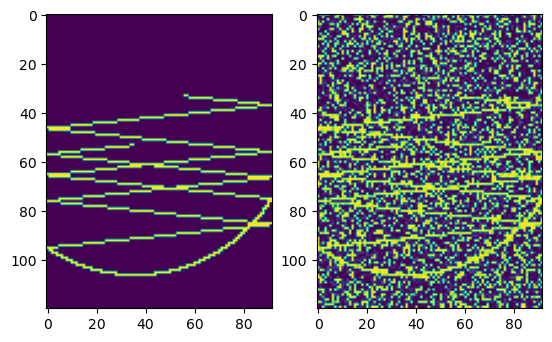

In [78]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(train_data[0][0])
ax[1].imshow(train_data_noisy[0][0])

In [79]:
class LinearAutoencoder(beacon.Module):
    def __init__(self, input_features):
        super().__init__()
        # Encoder
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_features, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, 16),
            torch.nn.ReLU()
        )
        # Decoder
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(16, 128),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.2),
            torch.nn.Linear(128, input_features),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [80]:
class ConvolutionAutoencoder(beacon.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, stride=1),  # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 8, 3, stride=1), # Output: (64, 15, 12)
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            # torch.nn.Flatten(1),
            # torch.nn.Linear(64*114*84, 128),
            # torch.nn.ReLU(),
        )
        
        self.decoder = torch.nn.Sequential(
            # torch.nn.Linear(128, 64*114*84),
            # torch.nn.ReLU(),
            # torch.nn.Unflatten(1, (64, 114, 84)),
            torch.nn.ConvTranspose2d(8, 16, 3, stride=1), # Output: (32, 30, 23)
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(16, 64, 3, stride=1), # Output: (16, 60, 45)
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 3, stride=1), # Output: (1, 120, 90)
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [81]:
summary(ConvolutionAutoencoder(), input_size=(1, 1, 120, 92))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionAutoencoder                   [1, 1, 120, 92]           --
├─Sequential: 1-1                        [1, 8, 114, 86]           --
│    └─Conv2d: 2-1                       [1, 64, 118, 90]          640
│    └─BatchNorm2d: 2-2                  [1, 64, 118, 90]          128
│    └─ReLU: 2-3                         [1, 64, 118, 90]          --
│    └─Conv2d: 2-4                       [1, 16, 116, 88]          9,232
│    └─BatchNorm2d: 2-5                  [1, 16, 116, 88]          32
│    └─ReLU: 2-6                         [1, 16, 116, 88]          --
│    └─Conv2d: 2-7                       [1, 8, 114, 86]           1,160
│    └─BatchNorm2d: 2-8                  [1, 8, 114, 86]           16
│    └─ReLU: 2-9                         [1, 8, 114, 86]           --
├─Sequential: 1-2                        [1, 1, 120, 92]           --
│    └─ConvTranspose2d: 2-10             [1, 16, 116, 88]          1,168
│   

In [82]:
autoencoder = ConvolutionAutoencoder().to("mps")
loss_function = torch.nn.MSELoss()
optimiser = torch.optim.Adam(autoencoder.parameters(), lr=0.003)

In [83]:
for epoch in tqdm(range(100)):
    optimiser.zero_grad()
    outputs = autoencoder(train_data_noisy.to("mps"))
    loss = loss_function(outputs, train_data.to("mps"))
    loss.backward()
    optimiser.step()

100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


In [84]:
autoencoder.eval()

with torch.no_grad():
    pred = autoencoder.to("cpu")(test_data_noisy[0].unsqueeze(0).to("cpu"))

Text(0.5, 1.0, 'Reconstructed Image')

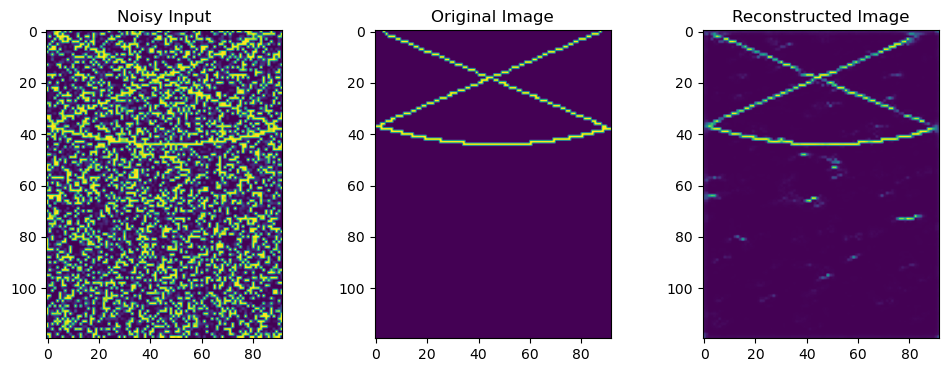

In [85]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(test_data_noisy[0][0].to("cpu"))
ax[1].imshow(test_data[0][0].to("cpu"))
ax[2].imshow(pred[0][0])

ax[0].set_title("Noisy Input")
ax[1].set_title("Original Image")
ax[2].set_title("Reconstructed Image")